# Analyse de données sismiques
## Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import pandas as pd

In [3]:
from obspy import read, read_inventory, UTCDateTime, Stream
from obspy.clients.fdsn import Client
from obspy.geodetics.base import gps2dist_azimuth

## Données

In [409]:
client = Client("RESIF") # Réseau français

### Informations sur le séisme
https://renass.unistra.fr/fr/evenements/fr2021gthfmw/#

In [495]:
starttime = UTCDateTime(2021,6,26,3,0,0)
duration = 3*60
location = (48.66, 7.82)

### Stations

In [451]:
stations = {'WALT', 'HOHE', 'CIEL', 'WLS', 'NEEW', 'SZBH', 'STR', 'ILLF', 'ZELS'}
direction_plans = {"horizontale" : ("N", "E", "W", "S", "1", "2",), "verticale" : ("Z",)}

### Récupération des données/métadonnées des stations

In [511]:
def get_S(name):
    return client.get_waveforms("FR", name, "00", "HH*", starttime, starttime + duration)

In [453]:
def get_inventory(name):
    return client.get_stations(network="FR", station=name, channel="HH*", starttime=starttime, level="response")

In [465]:
def download_inventory(stations=stations, filename='data/data.xml'):
    inventory = get_inventory(','.join(stations))
    inventory.write(filename, format='STATIONXML')
    return inventory

In [455]:
def download_S(stations=stations, filename='data/data.miniseed', display=True):
    S = Stream()
    for station in stations:
        try:
            S += get_S(station)
            text = f'Données de {station} récupérées'
        except Exception:
            text = f'Erreur à {station}'
        if display:
            print(text)
    S.write(filename, format="MSEED")
    return S

In [456]:
def download(stations=stations):
    return download_S(stations), download_inventory(stations)

In [466]:
def load():
    return read('data/data.miniseed'), read_inventory('data/data.xml')

### Analyse du signal

In [487]:
def filtration(T):
    T.detrend("demean")
    T.taper(0.1)
    T.filter("bandpass",freqmin=1,freqmax=5)

In [419]:
def amplitude_brut(T):
    t = T.data
    amplitude = max(abs(t))
    return amplitude

In [488]:
def gain(T, inventory):
    chinv = inventory.select(channel=T.id.split('.')[-1])[0][0][0]
    gain = chinv.response.instrument_sensitivity.value
    return gain

In [512]:
def dist_epi(station, inventory):
    stinv = inventory.select(station=station)[0][0]
    distance = gps2dist_azimuth(stinv.latitude, stinv.longitude, location[0], location[1])[0]
    return distance

In [422]:
def get_amplitudes(S, inventory, plot=False):
    amplitudes = {}
    
    for T in S:
        amplitude = amplitude_brut(T)/gain(T, inventory)
        station = T.id.split('.')[1]
        direction = T.id[-1]
        
        try:
            amplitudes[station]
        except KeyError:
            amplitudes[station] = {"horizontale": [], "verticale": []}
            
        for plan in direction_plans:
            if direction in direction_plans[plan]:
                amplitudes[station][plan].append(amplitude)
                
        if plot:
            T.plot()
    
    # np.average(amplitudes_values[plan])
        
    return amplitudes

#### Fréquences

In [534]:
def spectre(T):
    TFZ = np.fft.fft(T.data)/gain(T, inventory)
    f = np.fft.fftfreq(len(TFZ),T.stats.delta)

    plt.plot(f, np.abs(TFZ), label=T.id)
    plt.xlabel('frequence (Hz)')
    plt.ylabel('amplitude (m/s)')
    plt.xlim((0,10))
    plt.legend()

In [491]:
def freq_max(T):
    TFZ = np.fft.fft(T.data)/gain(T, inventory)
    f = np.fft.fftfreq(len(TFZ),T.stats.delta)
    amplitude = np.argmax(TFZ)
    frequence = np.abs(f[amplitude])
    return frequence

#### Magnitude locale
https://www.resif.fr/ressources/sismologie/dictionnaire-des-termes-de-sismologie/

In [442]:
def magnitude_locale(amplitude, distance):
    """
    amplitude : m/s
    distance : m
    """
    a = 0.018
    b = 2.17
    return np.log10(amplitude * 1000) + a * distance/1000 + b

### Récolte des données sous forme de tableau

In [460]:
def get_df(S, inventory, plot=False):
    data = get_amplitudes(S, inventory, plot=plot)
    df = pd.DataFrame.from_dict(data=data, orient='index')
    df.index.name = 'station'
    df['nom'] = df.apply(lambda row: inventory.select(station=row.name)[0][0].site.name, axis=1)
    df['horizontale'] = df['horizontale'].apply(np.average)
    df['verticale'] = df['verticale'].apply(np.average)
    df['distance'] = df.apply(lambda row: dist_epi(row.name, inventory=inventory), axis=1)
    df['frequence'] = df.apply(lambda row: freq_max(S.select(station=row.name, component='Z')[0]), axis=1)
    df['Ml'] = df.apply(lambda row: magnitude_locale(max(row.horizontale, row.verticale), row.distance), axis=1)
    df['Mlv'] = df.apply(lambda row: magnitude_locale(row.verticale, row.distance), axis=1)
    df = df.sort_values(by='distance')
    return df

In [ ]:
download()

In [493]:
# download() # télécharger les données
S, inventory = load() # charge les données
Skeep = S.copy() # copie les données
filtration(S) # filtre les données
df = get_df(S, inventory, plot=False)

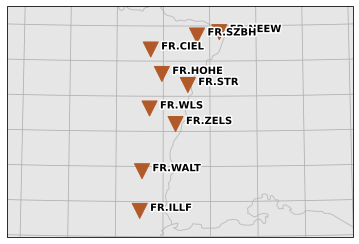

In [535]:
# S.plot()
ax = inventory.plot(projection="local")

In [463]:
df

,horizontale,verticale,nom,distance,frequence,Ml,Mlv
station,,,,,,,
STR,0.002694,0.000554,Strasbourg,9839.470651,2.983333,2.777480,2.090549
HOHE,0.000203,0.000180,Hohengœft,24730.920314,3.361111,1.922862,1.869979
CIEL,0.000246,0.000121,Vacanciel,38657.037798,1.388889,2.257550,1.949050
NEEW,0.000084,0.000066,Neewiller,38969.213465,2.449932,1.796989,1.689643
ZELS,0.000065,0.000068,Zelsheim,42143.981841,1.649954,1.763280,1.763280
WALT,0.000049,0.000097,Westhalten,87090.321688,1.366629,2.724182,2.724182
ILLF,0.000048,0.000028,Illfurth,116453.372036,1.749951,2.943513,2.718585


In [447]:
df.to_csv('output.csv', sep=';')
# df = pd.read_csv('output.csv', sep=';', index_col='station')

### Analyse des données récoltées

<AxesSubplot:xlabel='distance', ylabel='verticale'>

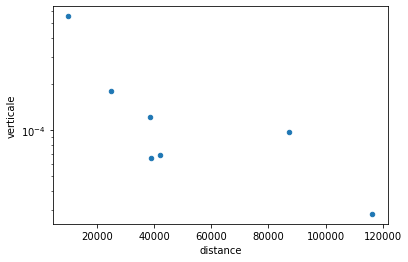

In [494]:
df.plot(kind='scatter', x='distance', y='verticale', logy=True)

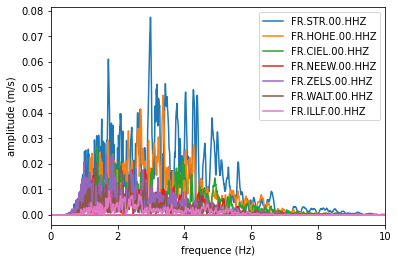

In [448]:
for row in df.itertuples():
    T = S.select(station=row.Index, component='Z')[0]
    spectre(T)
plt.savefig('graph.png')